In [37]:
import pandas as pd

In [38]:
X = pd.DataFrame({
    'city':['tokyo',None,'london','seattle','san francisco','tokyo'],
    'boolean':['yes','no',None,'no','no','yes'],
    'ordinal_column':['somewhat like','like','somewhat like','like','somewhat like','dislike'],
    'quantitative_column':[1,11,-.5,10,None,20]
})

In [39]:
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


## 填空分类特征

In [40]:
X.isnull().sum()

city                   1
boolean                1
ordinal_column         0
quantitative_column    1
dtype: int64

In [41]:
X['city'].value_counts().index[0]

'tokyo'

In [42]:
X['city'].fillna(X['city'].value_counts().index[0])

0            tokyo
1            tokyo
2           london
3          seattle
4    san francisco
5            tokyo
Name: city, dtype: object

### 自定义分类填充器

In [43]:
from sklearn.base import TransformerMixin

class CustomCategoryImputer(TransformerMixin):
    def __init__(self,cols = None):
        self.cols = cols
    
    def transform(self,df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0],inplace=True)
        return X
    
    def fit(self,*_):
        return self

In [44]:
cci = CustomCategoryImputer(cols=['city','boolean'])
cci.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


### 自定义定量填充器

In [45]:
from sklearn.impute import SimpleImputer

class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self,cols=None,strategy = 'mean'):
        self.cols = cols
        self.strategy = strategy
    
    def transform(self,df):
        X = df.copy()
        impute = SimpleImputer(strategy = self.strategy)
        for col in self.cols:
            X[col]=impute.fit_transform(X[[col]])
        return X
    
    def fit(self,*_):
        return self

In [46]:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'],strategy='mean')
cqi.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


In [47]:
# 使用流水线
from sklearn.pipeline import Pipeline

imputer = Pipeline([('quant',cqi),('category',cci)])
imputer.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


## 编码分类变量

### 定类等级的编码

In [48]:
# 用pandas自动找到分类变量并进行编码
pd.get_dummies(X,columns=['city','boolean'],prefix_sep='__')

,ordinal_column,quantitative_column,city__london,city__san francisco,city__seattle,city__tokyo,boolean__no,boolean__yes
0,somewhat like,1.0,0,0,0,1,0,1
1,like,11.0,0,0,0,0,1,0
2,somewhat like,-0.5,1,0,0,0,0,0
3,like,10.0,0,0,1,0,1,0
4,somewhat like,NaN,0,1,0,0,1,0
5,dislike,20.0,0,0,0,1,0,1


### 定序等级的编码

In [49]:
# 最简单的编码方法
ordering = ['dislike','somewhat like','like'] # 0-dislike 1-somewhat like 2-like

X['ordinal_column']

0    somewhat like
1             like
2    somewhat like
3             like
4    somewhat like
5          dislike
Name: ordinal_column, dtype: object

In [50]:
X['ordinal_column'].map(lambda x:ordering.index(x))

0    1
1    2
2    1
3    2
4    1
5    0
Name: ordinal_column, dtype: int64

### 将连续特征分箱

In [51]:
pd.cut(X['quantitative_column'],bins=3)

# bins 为整数时 为等宽分箱数

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4                NaN
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

In [52]:
pd.cut(X['quantitative_column'],bins=3,labels=False)

0    0.0
1    1.0
2    0.0
3    1.0
4    NaN
5    2.0
Name: quantitative_column, dtype: float64

### 扩展数值特征

根据胸部加速度计识别动作的数据集<br>

序号 x轴加速度 y轴加速度 z轴加速度 

在电脑前工作<br>
站立，走路，上下楼梯<br>
站立<br>
走路<br>
上下楼梯<br>
与人边走边聊<br> 
站立着讲话<br>

In [54]:
df = pd.read_csv('./data/activity_recognizer/1.csv',header= None)
df.columns= ['index','x','y','z','activity']
df.head()

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


In [55]:
df['activity'].value_counts(normalize=True)

7    0.515369
1    0.207242
4    0.165291
3    0.068793
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X = df[['x','y','z']]
y = df['activity']

knn_params = {
    'n_neighbors':[3,4,5,6]
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn,knn_params)
grid.fit(X,y)

/ana/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6]})

In [58]:
(grid.best_score_,grid.best_params_)

(0.7408140649873495, {'n_neighbors': 5})

#### 多项式特征

1. degree - 多项式特征的阶数 默认是2
2. interaction_only - 布尔值 若为true,只生成互相影响的特征,即不同阶数的特征 默认为false
3. include_bias - 布尔值 若为true,会生成一列阶数为0的偏差列 也就是列中全是数字1 默认为true

In [62]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2,include_bias=False,interaction_only=False)

X_poly =poly.fit_transform(X)
X_poly.shape

(162501, 9)

In [63]:
pd.DataFrame(X_poly,columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


In [64]:
%matplotlib inline
import seaborn as sns

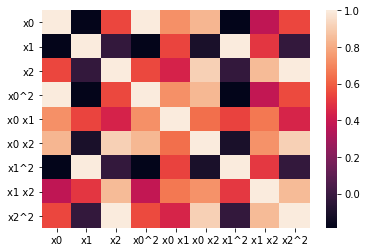

In [65]:
sns.heatmap(pd.DataFrame(X_poly,columns=poly.get_feature_names()).corr())

In [67]:
# 使用流水线
pipe_params = {
    'poly_features__degree':[1,2,3],
    'poly_features__interaction_only':[True,False],
    'classify__n_neighbors':[3,4,5,6]
}

pipe = Pipeline([('poly_features',poly),('classify',knn)])

grid = GridSearchCV(pipe,pipe_params)
grid.fit(X,y)

(grid.best_score_,grid.best_params_)

/ana/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


(0.7408140649873495,
 {'classify__n_neighbors': 5,
  'poly_features__degree': 1,
  'poly_features__interaction_only': True})